# Comparasion between the inverse filter and the Wiener filter

## Abstract
This lab aims to compare the results of image restoration using inverse filter and the Wiener filter respectively.

## Introduction
In this lab, we have an image of a book cover(cover.jpg) which is degradated by motion blur and Gaussian noise. Then we try to use the inverse filter and Wiener filter to restore the image respectively and see what is the difference between them. 

# Material
1. Import image  
I first download the cover image from the website and make it as a grayscale image. I have resized the image in half because it's too big. 

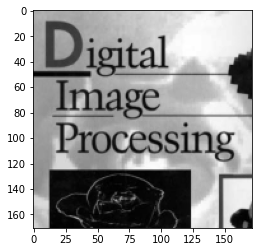

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from cmath import sin, pi, e, exp, cos
import math

img = cv2.imread('Resource/cover1.jpg', cv2.IMREAD_GRAYSCALE)

# resize the image because it's too big
width = img.shape[1] // 2
height = img.shape[0] // 2
dim = (width, height)
img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
plt.imshow(img, cmap='gray')

2. Apply motion blur

I learn from textbook that we have a formula to produce motion blur.

$ H(u,v) = \frac{T}{\pi(ua + vb)}sin[\pi(ua + vb)]e^{-j\pi(ua + vb)} $

Here I let a = b = 0.1 and T = 1 and I get the motion blur function $ H(u,v) $. 

Then I apply it to the original image.

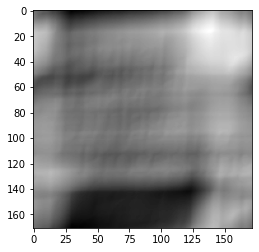

In [2]:
blur_arr = np.zeros(img.shape, dtype=complex)
for u in range(img.shape[0]):
    for v in range(img.shape[1]):
        # Avoid divisors of 0
        if(u + v == 0):
            blur_arr[u, v] = 1
            continue
        blur_arr[u, v] = sin(pi * (0.1 * (u) + 0.1 * (v))) * (cos(pi * (0.1 * (u) + 0.1 * (v))) - complex(0, math.sin(pi * (0.1 * (u) + 0.1 * (v))))) / (0.1 * (u) + 0.1 * (v)) / pi

fft_img = np.fft.fft2(img)
img_blur = blur_arr * fft_img
img_blur_fre = np.fft.ifft2(img_blur)
img_blur_fre = np.abs(img_blur_fre)
img_blur_fre = np.uint8(img_blur_fre)
plt.imshow(img_blur_fre, cmap='gray')

I also try to apply motion blur in the space domain. I generate a matrix where values on the main diagonal are 1 and the rest are 0. The kernel have a size of 19 * 19.

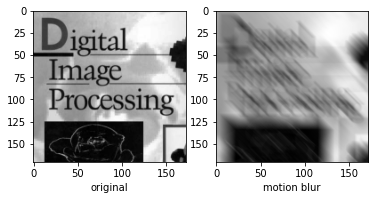

In [6]:
kernelSize = 19
kernel = np.zeros([kernelSize, kernelSize])
for i in range(kernelSize):
    kernel[i, i] = 1
kernel /= kernelSize
imgMotionBlur = cv2.filter2D(img, -1, kernel)
plt.subplot(1,2,1)
plt.xlabel('original')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.xlabel('motion blur')
plt.imshow(imgMotionBlur, cmap='gray')

This time, the result of motion blur seems much better.

3. Add Gaussian noise

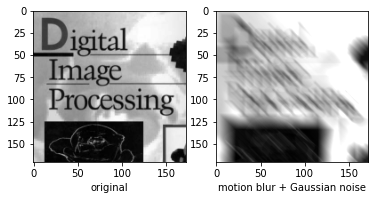

In [8]:
# add noise
row, col = imgMotionBlur.shape
gaussNoise = np.zeros((row, col), dtype=np.uint8)
# with a mean of 128 and a sigma of 0.1
cv2.randn(gaussNoise, 128, 0.1)
gaussNoise = (gaussNoise * 0.5).astype(np.uint8)
imgCorrupted = cv2.add(imgMotionBlur, gaussNoise)
plt.subplot(1,2,1)
plt.xlabel('original')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.xlabel('motion blur + Gaussian noise')
plt.imshow(imgCorrupted, cmap='gray')

4. Apply the inverse filter

I use the same method as the one in previous lab. Fisrt, pad both image and kernel to a specified size. Second, apply FFT to both image and kernel and make a shift. Then divide the image by the kernel. Finally, shift the result back and make a IFFT to get the result.

In [12]:
# padding
P = img.shape[0] + kernelSize - 1
if P % 2 == 1:
    P = P + 1
Q = img.shape[1] + kernelSize - 1
if Q % 2 == 1:
    Q = Q + 1
    
padded = np.pad(img, ((0, P - img.shape[0]), (0, Q - img.shape[1])), 'constant', constant_values=(0, 0))
padded_kernel = np.pad(kernel, ((1, P - kernelSize - 1), (1, Q - kernelSize - 1)), 'constant', constant_values=(0, 0))

fft_kernel = np.fft.fft2(padded_kernel)
fft_kernel_shift = np.fft.fftshift(fft_kernel) + 0.001
fft_img = np.fft.fft2(padded)
fft_img_shift = np.fft.fftshift(fft_img)

divRes_shift = fft_img_shift / fft_kernel_shift
divRes_ishift = np.fft.ifftshift(divRes_shift)
divRes = np.fft.ifft2(divRes_ishift)
divRes = np.abs(divRes)
divRes = np.uint8(divRes)

5. Apply the Wiener filter

The approximated formula is as follows.
$$ F(u,v) = [\frac{1}{H(u,v)} \frac{|H(u,v)|^{2}}{|H(u,v)|^{2} + K}] G(u,v) $$
where K is chosen interactively.

In [20]:
K = 0.3
fft_img_power = np.absolute(fft_kernel) ** 2
fft_kernel += 0.001
wiener_fre = fft_img_power * fft_img / fft_kernel / (fft_img_power + K)
wienerRes = np.fft.ifft2(wiener_fre)
wienerRes = np.abs(wienerRes)
wienerRes = np.uint8(wienerRes)



## Result

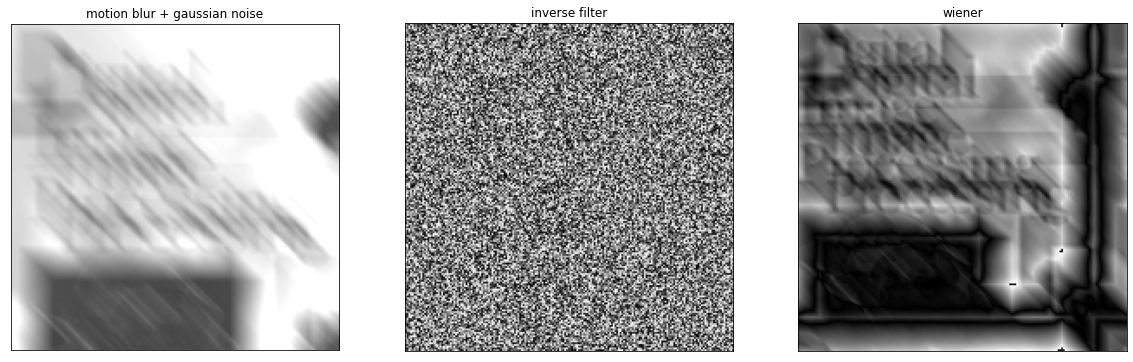

In [25]:
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1), plt.imshow(imgCorrupted, cmap='gray', vmin=0, vmax=255)
plt.title('motion blur + gaussian noise'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 3, 2), plt.imshow(divRes, cmap='gray', vmin=0, vmax=255)
plt.title('inverse filter'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 3, 3), plt.imshow(wienerRes, cmap='gray', vmin=0, vmax=255)
plt.title('wiener'), plt.xticks([]), plt.yticks([])

plt.show()

But the result looks too bad. Through communication with teacher, I got vital information that the image should not be padded because it could affect wiener filter. After communicating with Lei Yun, I changed a new kernel whose size is the same as the image so that padding is not needed. What's more, the values in the main diagonal of the kernel are not all 1, but with a specified distance.
So I do this lab again.

## Do the lab again

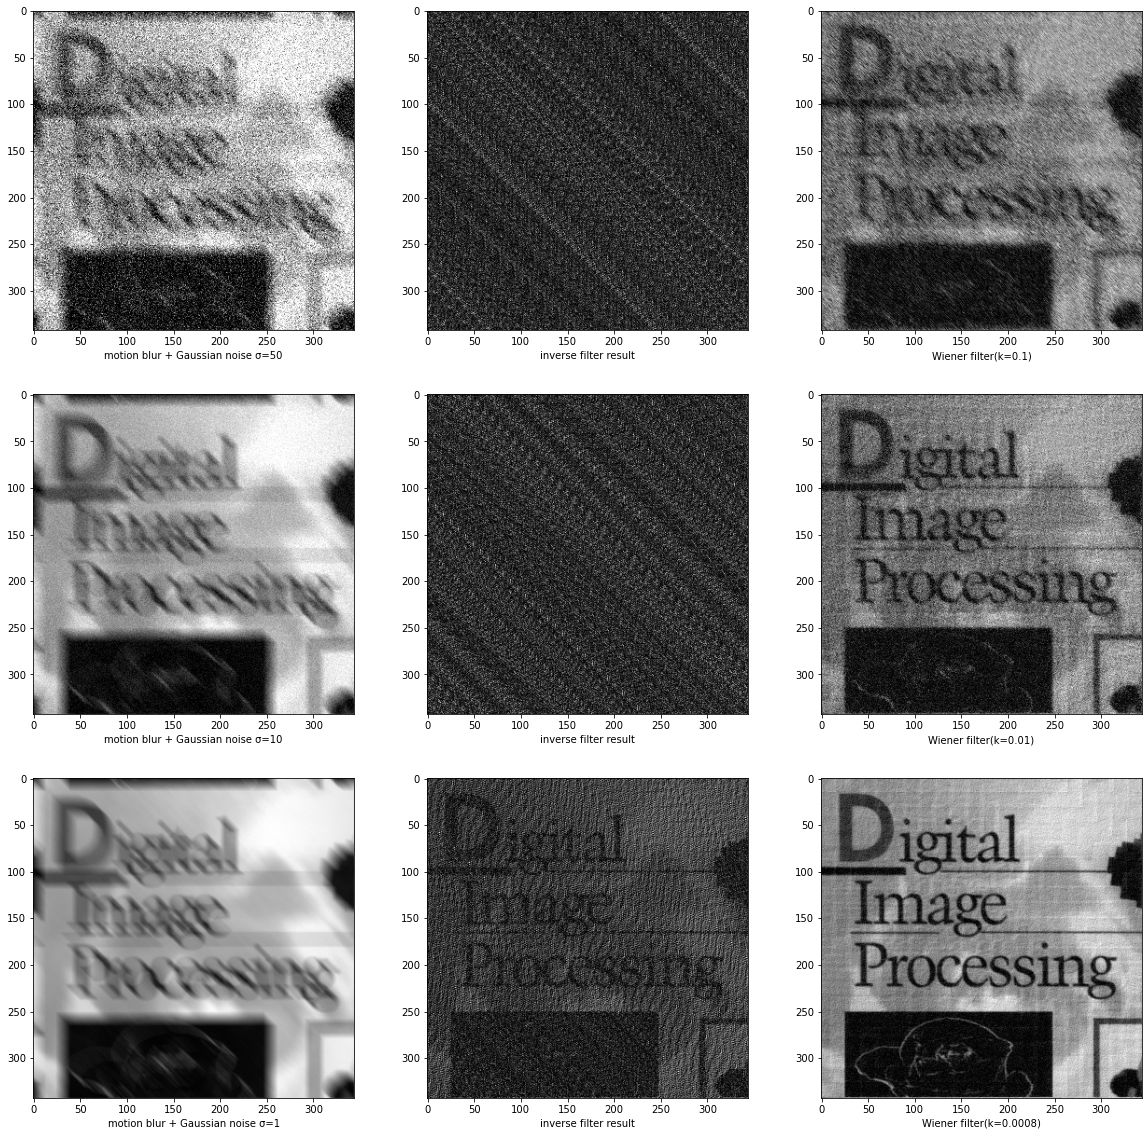

In [24]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('Resource/cover1.jpg', cv2.IMREAD_GRAYSCALE)

# apply motion blur
kernel = np.zeros(img.shape)
center_position = (img.shape[0] - 1) // 2
slope_tan = 1
distance = 16
for i in range(distance):
    offset = round(i * slope_tan)
    kernel[int(center_position + offset), int(center_position + offset)] = 1
kernel /= kernel.sum()
img_fft = np.fft.fft2(img)
kernel_fft = np.fft.fft2(kernel)
blurred = np.fft.ifft2(img_fft * kernel_fft)
blurred = np.abs(np.fft.fftshift(blurred))

# add gaussian noise
def add_gaussian_noise(img, sigma):
    if sigma < 0:
        return img
    gauss = np.random.normal(0, sigma, np.shape(img))
    noisy_img = img + gauss
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img


# inverse filter
def inverse_filter(img, kernel):
    img_fft = np.fft.fft2(img)
    kernel_fft = np.fft.fft2(kernel) + 0.001
    result = np.fft.ifft2(img_fft / kernel_fft)
    result = np.abs(np.fft.fftshift(result))
    return result

# wiener filter
def wiener_filter(img, kernel, K=0.01):
    img_fft = np.fft.fft2(img)
    kernel_fft = np.fft.fft2(kernel)
    kernel_fft_1 = np.conj(kernel_fft) / (np.abs(kernel_fft) ** 2 + K)
    result = np.fft.ifft2(img_fft * kernel_fft_1)
    result = np.abs(np.fft.fftshift(result))
    return result


sigmas = [50,10,1]
ks = [0.1,0.01,0.0008]
plt.figure(figsize=(20,20))
for i in range(len(sigmas)):
    # corrupted image
    img_corrupted = add_gaussian_noise(blurred, sigmas[i])
    plt.subplot(3, 3, 3 * i + 1)
    plt.xlabel(f"motion blur + Gaussian noise σ={sigmas[i]}")
    plt.imshow(img_corrupted,cmap='gray')

    # inverse filter
    plt.subplot(3,3,3*i+2)
    plt.xlabel("inverse filter result")
    plt.imshow(inverse_filter(img_corrupted, kernel),cmap='gray')

    # wiener filter
    plt.subplot(3,3,3*i+3)
    plt.xlabel(f"Wiener filter(k={ks[i]})")
    plt.imshow(wiener_filter(img_corrupted, kernel, ks[i]),cmap='gray')
plt.show()

## Conclusion
After changing a new kernel, the results are much much better. It proves that for wiener filter, the degradation kernel plays an important role. What's more the image should not be padded.
Besides, it is quite obvious in this lab that wiener filter is better than inverse filter for image restoration.